In [6]:
from matplotlib import pyplot as plt


import numpy as np
import scipy as sp
from scipy.special import expit, softmax #logistic fns 
from sklearn.metrics import confusion_matrix

import scipy.optimize as optimize
from sklearn import linear_model

import json
import time
import itertools
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from sklearn.metrics import confusion_matrix


In [12]:
import cv2 

# Function that converts a 1D vectorized image into a (nr x nc) 2D array
def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def plot_img(img,nr,nc):
    plt.figure(figsize=(nr, nc), dpi = 8)
    plt.imshow(unpackcw(img,nr,nc))
    
# resize img 2D array to specified nr,nc
def resize_img(img,nr,nc):
    return cv2.resize(img, dsize=(nr, nc), interpolation=cv2.INTER_CUBIC)

def resize_dataset(data, o_size, nrc):
    
    new_data = np.zeros((nrc*nrc, len(data[0])))
    for i in range(len(data[0])):
        img = unpackcw(data[:,i],o_size,o_size)
        img = resize_img(img,nrc,nrc)
        img = img.T
        img = img.reshape(nrc*nrc)
        new_data[:,i] = img
    return new_data

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    plt.colorbar(fraction=0.045)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    
    thresh = cm.max() / 1.7 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]), fontsize=22,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), fontsize=22,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)
    plt.show()
    
# quick visualizations

def acc(y_pred, label,sep):
    cm = confusion_matrix(label, (y_pred > sep)*1)
    return np.trace(cm) / float(np.sum(cm))

def plot_res(y_pred, labels, sep):
    
    acc_sep = acc(y_pred, labels, sep) 
    
    fig = plt.figure(figsize=(8,6)) # 8 is approximate width of half column to have text sizes work
    ax=fig.add_axes([0.15,0.15, .8, 0.8])

    marker_size=6
    
    line_legend_counter = 0
    noline_legend_counter = 0    
    for i in range(len(labels)):
        if (labels[i] == 0):
            if noline_legend_counter == 0:
                ax.plot(i, y_pred[i],'*k', markersize = marker_size, label = 'True class 0')
                noline_legend_counter = 1
            else:
                ax.plot(i, y_pred[i],'*k', markersize = marker_size)
        else:
            if line_legend_counter == 0:
                ax.plot(i, y_pred[i],'ob', markersize = marker_size, label = 'True class 1')
                line_legend_counter = 1
            else:   
                ax.plot(i, y_pred[i],'ob', markersize = marker_size)
    
    ax.plot(np.arange(0,len(labels)), sep*np.ones(len(labels)),"-.r", label = 'RC Boundary')
    ax.grid(alpha =.5, ls='-');
#     ax.set_xticks(np.arange(0,len(labels)))
    
    ax.set_xlabel("Image Number")
    ax.set_ylabel("RC Prediction")
    ax.set_title(f"RC classification performance, {int(acc_sep*len(labels))}/{len(labels)} correct, {round(100*np.round(acc_sep, 3),3)}%")
    return fig, ax



def plot_cm(y_pred, label, sep):
    cm = confusion_matrix(label, (y_pred > sep)*1)
    cm_norm = cm/np.array([label.count(0), label.count(1)])

    fig = plt.figure(figsize=(8,6)) # 8 is approximate width of half column to have text sizes work
    ax=fig.add_axes([0.15,0.15, .8, 0.8])
    ax.matshow(cm_norm, cmap = 'coolwarm', alpha = 0.5)
    for (image, lab), cnt in np.ndenumerate(cm_norm):
        ax.text(lab, image, '{:0.3f}'.format(cnt), ha='center', va='center', fontsize = 16)

    ax.set_title('Classification result')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticklabels([0,0, 1])
    ax.set_yticklabels([0,0, 1])
    ax.xaxis.set_ticks_position('bottom')
    
    return fig, ax
    
def do_both_plots(new_size,nq,nr,nc,nVar,img_iter):

    nimg=2000

    tVar="Train"
#     nVar="Noiseless"

    img_iteration=img_iter

    sn = "QRC_MNIST_{}x{}_{}{}_{}_nq{}_{}x{}_iter{}.txt".format(new_size,new_size,tVar,nimg,nVar,nq,nr,nc,img_iteration)

    with open(sn, "r") as fp:
        file = json.load(fp)

    label_train = file[0]
    rc_nodes_train = file[1]

#     # FIX ORDER NODES
#     for i in range(len(rc_nodes_train)):
#         rev_nodes = rc_nodes_train[i][::-1]
#         rc_nodes_train[i] = rev_nodes
    
    
    # train RC
    reg = linear_model.LogisticRegression(fit_intercept=True, solver = 'lbfgs', penalty = 'none')

    reg.fit(rc_nodes_train,label_train)

    y_pred = reg.predict_proba(rc_nodes_train)[:, 1]
    W, W_0 = reg.coef_, reg.intercept_ # weights
    
    sep = 0.5

    plot_res(y_pred, label_train, sep)
    plot_cm(y_pred, label_train, sep)


    tVar="Test"
    nimg=200

    sn = "QRC_MNIST_{}x{}_{}{}_{}_nq{}_{}x{}_iter{}.txt".format(new_size,new_size,tVar,nimg,nVar,nq,nr,nc,img_iteration)

    with open(sn, "r") as fp:
        file = json.load(fp)

    label_test = file[0]
    rc_nodes_test = file[1]

#     # FIX ORDER NODES
#     for i in range(len(rc_nodes_test)):
#         rev_nodes = rc_nodes_test[i][::-1]
#         rc_nodes_test[i] = rev_nodes
    
    # Test
    y_pred_test = reg.predict(rc_nodes_test)

    plot_res(y_pred_test, label_test, sep)
    plot_cm(y_pred_test, label_test, sep)

def plot_av_Train_nodes(new_size,nq,nr,nc,img_iter,nVar="Noiseless",tVar="Train",nmeas=new_size**2):
    
    if (tVar=="Train"):
        nimg=2000
        offs=1000
    else:
        nimg=200
        offs=100 

    

    img_iteration=img_iter

    sn = "QRC_MNIST_{}x{}_{}{}_{}_nq{}_{}x{}_iter{}_rightcalU.txt".format(new_size,new_size,tVar,nimg,nVar,nq,nr,nc,img_iteration)

    with open(sn, "r") as fp:
        file = json.load(fp)

    label_train = file[0]
    rc_nodes_train = file[1]
    
#     # FIX ORDER NODES
#     for i in range(len(rc_nodes_train)):
#         rev_nodes = rc_nodes_train[i][::-1]
#         rc_nodes_train[i] = rev_nodes

    rc_av_0s = np.mean(rc_nodes_train[:offs],axis=0)
    rc_std_0s = np.std(rc_nodes_train[:offs],axis=0)

    rc_av_1s = np.mean(rc_nodes_train[offs:],axis=0)
    rc_std_1s = np.std(rc_nodes_train[offs:],axis=0)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.errorbar(np.arange(rc_av_0s.shape[0]),rc_av_0s, yerr=rc_std_0s, label="digit 0",c='tab:blue',fmt='.')
    ax.errorbar(np.arange(rc_av_1s.shape[0]),rc_av_1s, yerr=rc_std_1s, label="digit 1",c='tab:red',fmt='.')

    if (nq == 4):
        fs = 8
    elif (nq == 8):
        fs = 10
    else:
        fs = 12
          
    for j in range(int(nmeas/(nq-nr))):   
        start, end = j*(nq-nr)-0.5, (j+1)*(nq-nr)-0.5
        ax.axvspan(start, end, alpha=.2, color='green')
        trans = ax.get_xaxis_transform()
        ax.text(((start + end) / 2)-0.8, 0.015, '$\Delta t$', transform=trans,size=fs)

#     for j in range(int(nmeas)):   
#         start, end = j-0.5, (j)+0.5
#         ax.axvspan(start, end, alpha=.2, color='green')
#         trans = ax.get_xaxis_transform()
#         ax.text(((start + end) / 2)-0.5, 0.015, '$\Delta t$', transform=trans,size=fs)

    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

#     xxticks_f = np.arange(nmeas)

#     plt.xticks(xxticks_f,xxticks_f)

    plt.xlabel("rc nodes x[n]", fontsize=14)
    plt.ylabel("Average rc node", fontsize=14)
    plt.legend()
    plt.title("MNIST "+str(new_size)+"x"+str(new_size)+", "+str(2*nr)+"-qubit circuit, average rc node on "+str(offs)+" images")
    
    
    plt.text(27, 0.60, tVar, fontsize=17)

#     plt.text(12, 0.10, tVar, fontsize=17)

    
#     sv = "Nodes_"+str(tVar)+"_"+sn
#     plt.savefig(str(sv)+'.png')

    plt.show()

def plot_rc_nodes(new_size,nr,nc,img_iter,nVar="Noiseless"):
    
    nq=2*nr
    
    img_iteration=img_iter
    
    tVar="Train"
    nimg=2000
    

    sn = "QRC_MNIST_{}x{}_{}{}_{}_nq{}_{}x{}_iter{}.txt".format(new_size,new_size,tVar,nimg,nVar,2*nr,nr,nc,img_iteration)

    with open(sn, "r") as fp:
        file = json.load(fp)

    label_train = np.array(file[0])
    rc_train = np.array(file[1])
    

    tVar="Test"
    nimg=200
    

    sn = "QRC_MNIST_{}x{}_{}{}_{}_nq{}_{}x{}_iter{}.txt".format(new_size,new_size,tVar,nimg,nVar,2*nr,nr,nc,img_iteration)

    with open(sn, "r") as fp:
        file = json.load(fp)

    label_test = np.array(file[0])
    rc_test = np.array(file[1])

    
    # fix train order, ie reverse

    for i in range(len(rc_train)):
        rev_nodes = rc_train[i][::-1]
        rc_train[i] = rev_nodes

    for i in range(len(rc_test)):
        rev_nodes = rc_test[i][::-1]
        rc_test[i] = rev_nodes

    # alpha value
    av=0.3
    # train
       
    offs=1000
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for i in range(len(rc_train[0])):
        ax.scatter(np.ones(rc_train[:offs].shape[0])*i,rc_train[:offs,i],c='tab:blue',alpha=av, marker='.')
        ax.scatter(np.ones(rc_train[offs:].shape[0])*i,rc_train[offs:,i],c='tab:red',alpha=av, marker='.')
  

    if (nq == 4):
        fs = 8
    elif (nq == 8):
        fs = 10
    else:
        fs = 12
        
    for j in range(int(new_size**2/nr)):   
        start, end = j*nr-0.5, (j+1)*nr-0.5
        ax.axvspan(start, end, alpha=.2, color='green')
        trans = ax.get_xaxis_transform()
        ax.text(((start + end) / 2)-1.2, 0.015, '$\Delta t$', transform=trans,size=fs)

    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    
    
    plt.xlabel("rc nodes x[n]", fontsize=14)
    plt.ylabel("rc node", fontsize=14)
    plt.title(nVar, fontsize=14)
    
    d0 = mlines.Line2D([], [], color='tab:blue', marker='.', linestyle='None',
                          markersize=7, label='digit 0')
    d1 = mlines.Line2D([], [], color='tab:red', marker='.', linestyle='None',
                          markersize=7, label='digit 1')
    

    plt.legend(handles=[d0,d1],fontsize=11)


    
    plt.text(30, 0.62, "Train", fontsize=17)
    plt.show()
    
    
    # test
    
    offs=100

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for i in range(len(rc_test[0])):
        ax.scatter(np.ones(rc_test[:offs].shape[0])*i,rc_test[:offs,i],c='tab:blue',alpha=av, marker='.')
        ax.scatter(np.ones(rc_test[offs:].shape[0])*i,rc_test[offs:,i],c='tab:red',alpha=av, marker='.')
  
    if (nq == 4):
        fs = 8
    elif (nq == 8):
        fs = 10
    else:
        fs = 12
        
    for j in range(int(new_size**2/nr)):   
        start, end = j*nr-0.5, (j+1)*nr-0.5
        ax.axvspan(start, end, alpha=.2, color='green')
        trans = ax.get_xaxis_transform()
        ax.text(((start + end) / 2)-1.2, 0.015, '$\Delta t$', transform=trans,size=fs)


    plt.xlabel("rc nodes x[n]", fontsize=14)
    plt.ylabel("rc node", fontsize=14)
    plt.title(nVar, fontsize=14)

    d0 = mlines.Line2D([], [], color='tab:blue', marker='.', linestyle='None',
                          markersize=7, label='digit 0')
    d1 = mlines.Line2D([], [], color='tab:red', marker='.', linestyle='None',
                          markersize=7, label='digit 1')
    

    plt.legend(handles=[d0,d1],fontsize=11)

    #,bbox_to_anchor=(1.05, 1), loc='upper left'

    
    plt.text(30, 0.62, "Test", fontsize=17)
    plt.show()
  

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


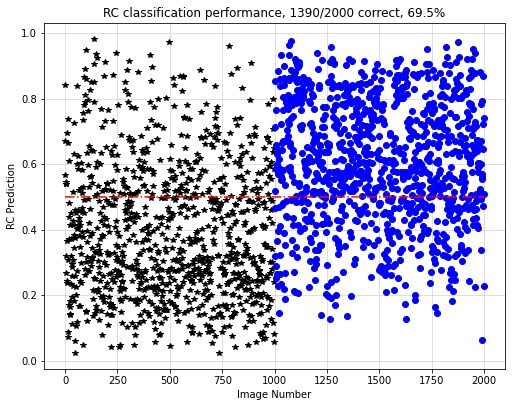

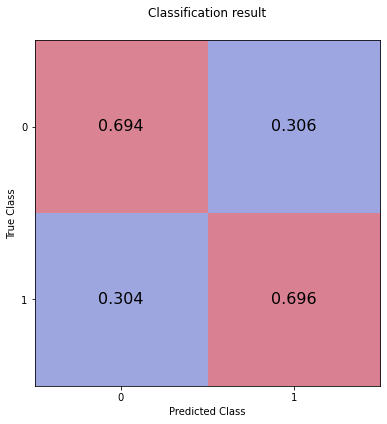

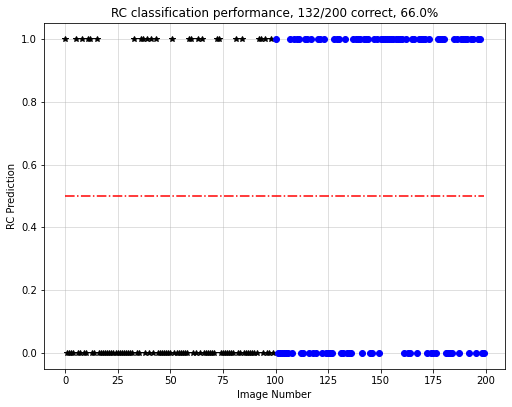

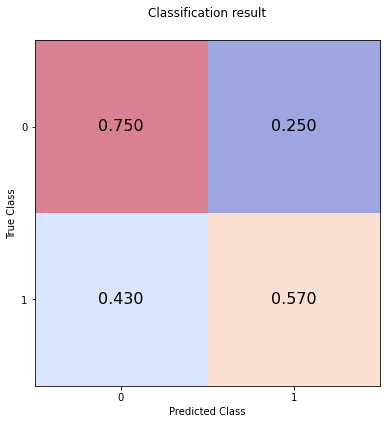

In [10]:
new_size=8

# nq=4

nr=2
nq=2*nr

nVar="Noiseless"
# nVar="Depol_01_1"
# nVar="Noise_thermal_8q"
# nVar="Noisy"
# nVar="Melbourne_artificial_16q"


# nr=int(nq/2)


nc = int(new_size/nr)*new_size

# nc = int(nc/2)


img_iter=0

do_both_plots(new_size,nq,nr,nc,nVar,img_iter)







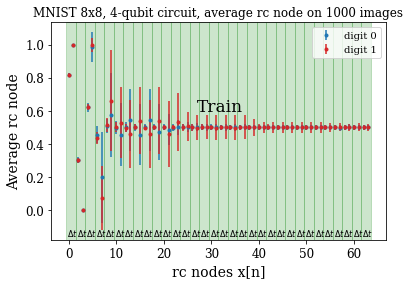

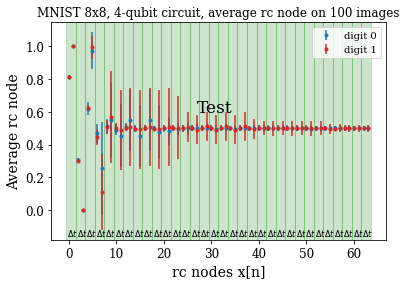

In [13]:
# notice we fix the num of measurements

# new_size=8

# # nq=8
# nr=int(nq/2)
# nc = int(new_size/nr)*new_size
img_iter=0

nmeas = int(new_size**2)


tVar="Train"

plot_av_Train_nodes(new_size,nq,nr,nc,img_iter,nVar=nVar,tVar=tVar,nmeas=nmeas)

tVar="Test"

plot_av_Train_nodes(new_size,nq,nr,nc,img_iter,nVar=nVar,tVar=tVar,nmeas=nmeas)


# plot_rc_nodes(new_size,nr,nc,img_iter,nVar=nVar)

In [356]:
import matplotlib.image as mpimg

img_nTr = mpimg.imread('Nodes_Train_QRC_MNIST_8x8_Train2000_Noiseless_nq16_8x8_iter0.txt.png')
img_nTe = mpimg.imread('Nodes_Test_QRC_MNIST_8x8_Test200_Noiseless_nq16_8x8_iter0.txt.png')

conf_Tr = mpimg.imread('confusion1.png')
conf_Te = mpimg.imread('confusion2.png')

# show old and new image
# show original image
fig = plt.figure()

# show original image
fig.add_subplot(221)
plt.title('1')
plt.imshow(img_nTr)

fig.add_subplot(222)
plt.title('2')
plt.imshow(conf_Tr)

fig.add_subplot(223)
plt.title('3')
plt.imshow(img_nTe)

fig.add_subplot(224)
plt.title('4')
plt.imshow(conf_Te)

plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: 'Nodes_Train_QRC_MNIST_8x8_Train2000_Noiseless_nq16_8x8_iter0.txt.png'

0